In [11]:
#
# Imports
#

import os
import glob
import cv2
import random
import time
import pandas as pd
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import imageio
#imageio.plugins.ffmpeg.download()

from skimage.feature import hog
from sklearn.utils import shuffle
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split
from sklearn.externals import joblib
from sklearn.decomposition import PCA
from scipy.ndimage.measurements import label
from collections import deque
from moviepy.editor import VideoFileClip
from IPython.display import HTML

%matplotlib inline

In [12]:
# 
# Data loading and augmentation functions
#

def loadDataset():
    datasets = [
        {
            'directory': 'object-dataset',
            'names': ['frame', 'xmin', 'ymin', 'xmax', 'ymax', 'occluded', 'label', 'attributes'],
            'car_label': 'car',
            'sep': ' '
        },
        {
            'directory': 'object-detection-crowdai',
            'names': ['xmin', 'ymin', 'xmax', 'ymax', 'frame', 'label', 'preview'],
            'car_label': 'Car',
            'sep': None
        }
    ]

    for data in datasets:
        annotation_root = os.path.join('annotations', data['directory'])
        annotation_path = os.path.join(annotation_root, 'labels.csv')

        df = pd.read_csv(annotation_path, sep=data['sep'], header=None, names=data['names'])

        # filter out non-cars
        cars = df[df.label == data['car_label']]
        try:
            cars = cars.drop(['label', 'attributes', 'occluded'], 1)
        except ValueError:
            cars = cars.drop(['label', 'preview'], 1)

        cars = cars.groupby(['frame'], as_index = False)
        cars = cars.aggregate(lambda x : list(x))

        cars.reset_index()
        cars['frame'] = cars['frame'].apply(lambda x: os.path.join(annotation_root, x))

        yield cars

def carGenerator(sample_size=None):
    print('\033[1mLoading car dataset...\033[0m')

    # load GTI/KITTI datasets
    gti_df = pd.DataFrame(columns=['frame', 'xmin', 'ymin', 'xmax', 'ymax'])
    for vehicle_dir in os.listdir('annotations/vehicles'):
        vehicle_dir = os.path.join('annotations/vehicles', vehicle_dir)
        if os.path.isdir(vehicle_dir):
            frames = glob.glob(os.path.join(vehicle_dir, '*.png'))
            xmin = [[0]] * len(frames)
            ymin = [[0]] * len(frames)
            xmax = [[64]] * len(frames)
            ymax = [[64]] * len(frames)
            data = pd.DataFrame({'frame': frames, 'xmin': xmin, 'ymin': ymin, 'xmax': xmax, 'ymax': ymax})
            gti_df = gti_df.append(data)

    generator = loadDataset()
    autti_df = next(generator)
    crowdai_df = next(generator)

    # Reduce the sample size if necessary
    if sample_size:
        autti_df = autti_df.sample(frac=1).reset_index(drop=True)
        crowdai_df = crowdai_df.sample(frac=1).reset_index(drop=True)
        gti_df = gti_df.sample(frac=1).reset_index(drop=True)
        autti_df = autti_df[:sample_size]
        crowdai_df = autti_df[:sample_size]
        gti_df = gti_df[:sample_size]

    cars_df = pd.concat([gti_df, autti_df, crowdai_df])

    for i, row in cars_df.iterrows():
        filename = row['frame']
        img = mpimg.imread(filename)
        if np.max(img) <= 1:
            img = img * 255
            img = img.astype(np.uint8)

        for j in range(len(row['xmin'])):
            if row['ymin'][j] == row['ymax'][j] or row['xmin'][j] == row['xmax'][j]:
                continue

            # crop image to correct section and resize
            img_tosearch = img[
                int(row['ymin'][j]):int(row['ymax'][j]), 
                int(row['xmin'][j]):int(row['xmax'][j]), 
                :
            ]
            img_tosearch = cv2.resize(img_tosearch, (64, 64))
            yield img_tosearch

def notCarGenerator(sample_size=None):
    print('\033[1mLoading non-car dataset...\033[0m')

    # load non-car dataset
    not_cars = []
    for non_vehicle_dir in os.listdir('annotations/non-vehicles'):
        non_vehicle_dir = os.path.join('annotations/non-vehicles', non_vehicle_dir)
        if os.path.isdir(non_vehicle_dir):
            not_cars.extend(glob.glob(os.path.join(non_vehicle_dir, '*.png')))

    if sample_size:
        not_cars = shuffle(not_cars)
        not_cars = not_cars[0:sample_size]

    # Functions for augmenting dataset
    basic_image = lambda image: image
    flip_image = lambda image: cv2.flip(image, 1)
    augmentation_funcs = [basic_image, flip_image]

    for filename in not_cars:
        img = mpimg.imread(filename)

        for func in augmentation_funcs:
            augmented_img = func(img)
            if np.max(augmented_img) <= 1:
                augmented_img = augmented_img * 255
                augmented_img = augmented_img.astype(np.uint8)
                
            yield augmented_img

Loading car dataset...
Loading non-car dataset...


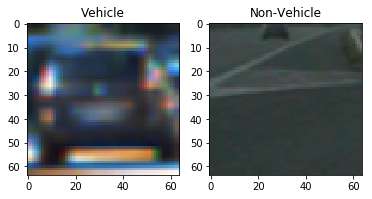

In [13]:
# Test data loading
car_generator = carGenerator(1)
car = next(car_generator)

not_car_generator = notCarGenerator(1)
not_car = next(not_car_generator)

fig = plt.figure()
plt.subplot(121)
plt.title('Vehicle')
plt.imshow(car)
plt.subplot(122)
plt.title('Non-Vehicle')
plt.imshow(not_car)

In [14]:
#
# Helper functions
#

def getHogFeatures(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient,
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  block_norm= 'L2-Hys',
                                  cells_per_block=(cell_per_block, cell_per_block),
                                  transform_sqrt=True,
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    else:
        features = hog(img, orientations=orient,
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block),
                       block_norm= 'L2-Hys',
                       transform_sqrt=True,
                       visualise=vis, feature_vector=feature_vec)
        return features

def binSpatial(img, size=(32, 32)):
    features = cv2.resize(img, size).ravel()
    return features

def colorHist(img, nbins=32, bins_range=(0, 256), separate_channels=False):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)

    # Concatenate the histograms into a single feature vector
    if not separate_channels:
        hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
        return hist_features
    else:
        return (channel1_hist, channel2_hist, channel3_hist)

def extractFeatures(generator, sample_size=None, color_space='RGB', spatial_size=(32, 32), hist_bins=32, orient=9,
                    pix_per_cell=8, cell_per_block=2, hog_channel=0, spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    for image in generator(sample_size):
        file_features = []

        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            feature_image = convertColor(image, 'RGB2' + color_space)
        else: feature_image = np.copy(image)

        if spatial_feat == True:
            spatial_features = binSpatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            hist_features = colorHist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_vec, image = getHogFeatures(feature_image[:,:,channel], orient, pix_per_cell, cell_per_block,
                                                vis=True, feature_vec=True)
                    if np.isnan(hog_vec).any():
                        hog_vec = [0 if np.isnan(x) else x for x in hog_vec]
                    hog_features.append(hog_vec)
                hog_features = np.ravel(hog_features)
            else:
                hog_features = getHogFeatures(feature_image[:,:,hog_channel], orient,
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)

            file_features.append(hog_features)
        features.append(np.concatenate(file_features))

    return features

def slideWindow(img, x_start_stop=[None, None], y_start_stop=[None, None], xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]

    # Compute the span of the region to be searched
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]

    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))

    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step)
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step)

    # Initialize a list to append window positions to
    window_list = []
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]

            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))

    return window_list

def convertColor(img, conv='RGB2YCrCb'):
    converted_img = None
    if conv == 'RGB2YCrCb':
        converted_img = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    elif conv == 'RGB2LUV':
        converted_img = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    elif conv == 'RGB2HSV':
        converted_img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    elif conv == 'RGB2HLS':
        converted_img = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    elif conv == 'RGB2YUV':
        converted_img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)

    if conv == 'BGR2YCrCb':
        converted_img = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    elif conv == 'BGR2LUV':
        converted_img = cv2.cvtColor(img, cv2.COLOR_BGR2LUV)
    elif conv == 'BGR2HSV':
        converted_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    elif conv == 'BGR2HLS':
        converted_img = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    elif conv == 'BGR2YUV':
        converted_img = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)

    if np.max(converted_img) <= 1:
        converted_img = converted_img * 255
        converted_img = converted_img.astype(np.uint8)
    return converted_img

def addHeat(heatmap, bbox_list):
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    return heatmap

def applyThreshold(heatmap, threshold):
    heatmap[heatmap <= threshold] = 0
    return heatmap

def drawBoxes(img, bboxes, color=(0, 0, 255), thick=6):
    imcopy = np.copy(img)
    for bbox in bboxes:
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)

    return imcopy

def drawLabeledBoxes(img, labels):
    imcopy = np.copy(img)
    for car_number in range(1, labels[1]+1):
        nonzero = (labels[0] == car_number).nonzero()

        # Identify x and y values of pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])

        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        cv2.rectangle(imcopy, bbox[0], bbox[1], (0,0,255), 6)

    return imcopy

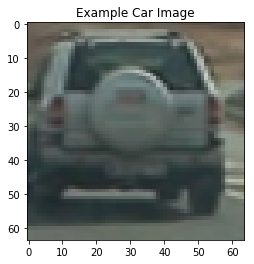

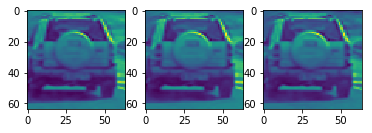

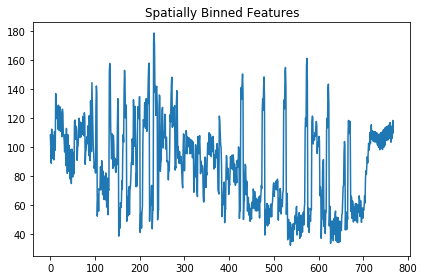

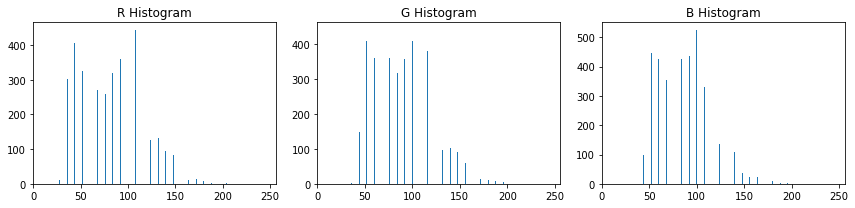

Text(0.5,1,'HOG Channel 3')

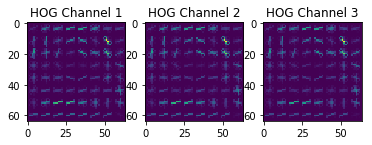

In [15]:
# Test each feature extraction method
image = mpimg.imread('annotations/vehicles/GTI_MiddleClose/image0066.png')
image = image * 255
image = image.astype(np.uint8)

fig = plt.figure()
plt.imshow(image.astype(np.uint8))
plt.title('Example Car Image')

fig = plt.figure()
plt.subplot(131)
plt.imshow(image[:,:,0])
plt.subplot(132)
plt.imshow(image[:,:,1])
plt.subplot(133)
plt.imshow(image[:,:,2])

# Spatial binning
feature_vec = binSpatial(image.astype(np.float32), size=(16, 16))
fig = plt.figure()
plt.plot(feature_vec)
plt.title('Spatially Binned Features')
plt.tight_layout()
plt.show()

# Color histogram
channel1, channel2, channel3 = colorHist(image, nbins=32, bins_range=(0, 256), separate_channels=True)
bin_edges = channel1[1]
bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
if channel1 is not None:
    fig = plt.figure(figsize=(12,3))
    plt.subplot(131)
    plt.bar(bin_centers, channel1[0])
    plt.xlim(0, 256)
    plt.title('R Histogram')
    plt.subplot(132)
    plt.bar(bin_centers, channel2[0])
    plt.xlim(0, 256)
    plt.title('G Histogram')
    plt.subplot(133)
    plt.bar(bin_centers, channel3[0])
    plt.xlim(0, 256)
    plt.title('B Histogram')
    fig.tight_layout()
    plt.show()
else:
    print('Your function is returning None for at least one variable...')
    
# HOG
features1, hog_image1 = getHogFeatures(image[:,:,0], orient=11, pix_per_cell=8, cell_per_block=2, vis=True, feature_vec=False)
features2, hog_image2 = getHogFeatures(image[:,:,1], orient=11, pix_per_cell=8, cell_per_block=2, vis=True, feature_vec=False)
features3, hog_image3 = getHogFeatures(image[:,:,2], orient=11, pix_per_cell=8, cell_per_block=2, vis=True, feature_vec=False)

fig = plt.figure()
plt.subplot(131)
plt.imshow(hog_image1)
plt.title('HOG Channel 1')
plt.subplot(132)
plt.imshow(hog_image2)
plt.title('HOG Channel 2')
plt.subplot(133)
plt.imshow(hog_image3)
plt.title('HOG Channel 3')

In [16]:
#
# Classification model class
#

class Model(object):

    def __init__(self, c_space, orient, ppc, cpb, hog_chan, spatial_s, hist_b, spatial_f, hist_f, hog_f):
        self.sample_size = None

        self.color_space = c_space # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
        self.orient = orient  # HOG orientations
        self.pix_per_cell = ppc # HOG pixels per cell
        self.cell_per_block = cpb # HOG cells per block
        self.hog_channel = hog_chan # Can be 0, 1, 2, or "ALL"
        self.spatial_size = spatial_s # Spatial binning dimensions
        self.hist_bins = hist_b    # Number of histogram bins
        self.spatial_feat = spatial_f # Spatial features on or off
        self.hist_feat = hist_f # Histogram features on or off
        self.hog_feat = hog_f # HOG features on or off

        self.X_scaler = StandardScaler()
        self.pca = PCA(svd_solver='randomized', n_components=1000, random_state=815)
        self.clf = LinearSVC(C=0.001)

    def train(self, train, sample_size):
        self.sample_size = sample_size

        # Load classifier and data or generate it
        start = time.time()
        X_test, y_test = self.loadClassifier(train)
        score = round(self.clf.score(X_test, y_test), 4)
        elapsed_sec = round(time.time() - start, 3)

        print('Test Accuracy:\033[1m', score, '\033[0m')
        print('Test time:\033[1m', elapsed_sec, '\033[0m')

    def predict(self, features):
        return self.clf.predict(features)

    def storeClassifier(self, X_test, y_test):
        joblib.dump((self.clf, self.X_scaler, self.pca, X_test, y_test), 'clf.pkl')

    def loadClassifier(self, train):
        if not os.path.exists('clf.pkl') or train:
            return self.generateClassifier()
        else:
            loaded_data = joblib.load('clf.pkl')
            self.clf = loaded_data[0]
            self.X_scaler = loaded_data[1]
            self.pca = loaded_data[2]
            X_test = loaded_data[3]
            y_test = loaded_data[4]
            return (X_test, y_test)

    def generateClassifier(self):
        car_features = extractFeatures(carGenerator, self.sample_size, color_space=self.color_space,
                                       spatial_size=self.spatial_size, hist_bins=self.hist_bins,
                                       orient=self.orient, pix_per_cell=self.pix_per_cell,
                                       cell_per_block=self.cell_per_block,
                                       hog_channel=self.hog_channel, spatial_feat=self.spatial_feat,
                                       hist_feat=self.hist_feat, hog_feat=self.hog_feat)
        not_car_features = extractFeatures(notCarGenerator, self.sample_size, color_space=self.color_space,
                                           spatial_size=self.spatial_size, hist_bins=self.hist_bins,
                                           orient=self.orient, pix_per_cell=self.pix_per_cell,
                                           cell_per_block=self.cell_per_block,
                                           hog_channel=self.hog_channel, spatial_feat=self.spatial_feat,
                                           hist_feat=self.hist_feat, hog_feat=self.hog_feat)

        # Create an array stack of feature vectors
        X = np.vstack((car_features, not_car_features)).astype(np.float64)

        # Define the labels vector
        y = np.hstack((np.ones(len(car_features)), np.zeros(len(not_car_features))))

        # Split up data into randomized training and test sets
        rand_state = np.random.randint(0, 100)
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=rand_state)

        # Fit a per-column scaler and reduce dimensionality
        self.X_scaler.fit(X_train)
        X_train = self.X_scaler.transform(X_train)
        X_test = self.X_scaler.transform(X_test)
        self.pca.fit(X_train)
        X_train = self.pca.transform(X_train)
        X_test = self.pca.transform(X_test)

        self.clf.fit(X_train, y_train)
        self.storeClassifier(X_test, y_test)

        return (X_test, y_test)

In [51]:
#
# Vehicle detection class
#

class Detector(object):

    def __init__(self, train, sample_size):
        self.x_start = 0
        self.x_stop = 1280
        self.y_start = 300
        self.y_stop = 656
        self.scales = [1.0, 1.5, 2.0, 3.5]
        self.xy_window = (64, 64)
        self.xy_overlap = (0.75, 0.75)

        self.color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
        self.orient = 11  # HOG orientations
        self.pix_per_cell = 8 # HOG pixels per cell
        self.cell_per_block = 2 # HOG cells per block
        self.hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
        self.spatial_size = (32, 32) # Spatial binning dimensions
        self.hist_bins = 32    # Number of histogram bins
        self.spatial_feat = True # Spatial features on or off
        self.hist_feat = True # Histogram features on or off
        self.hog_feat = True # HOG features on or off
        self.heat_threshold = 12
        self.confidence_threshold = 35

        self.heatmaps_frames = 12
        self.heatmaps = deque(maxlen=self.heatmaps_frames)

        self.classify = Model(
            self.color_space,
            self.orient,
            self.pix_per_cell,
            self.cell_per_block,
            self.hog_channel,
            self.spatial_size,
            self.hist_bins,
            self.spatial_feat,
            self.hist_feat,
            self.hog_feat,
        )
        self.classify.train(train, sample_size)

    def detectCars(self, img):
        hot_windows = self.findCars(img)

        # Create heatmap
        heat = np.zeros_like(img[:,:,0]).astype(np.float)
        heat = addHeat(heat, hot_windows)
        self.heatmaps.append(heat)

        avg_heatmap = sum(self.heatmaps) / len(self.heatmaps)
        thresh_heatmap = applyThreshold(avg_heatmap, self.heat_threshold)
        thresh_heatmap = np.clip(thresh_heatmap, 0, 255)
        labels = label(thresh_heatmap)

        boxes = drawLabeledBoxes(np.copy(img), labels)
        # plt.imshow(boxes)
        # plt.show()
        return boxes

    def singleImgFeatures(self, img):
        img_features = []
        if self.color_space != 'RGB':
            feature_image = convertColor(img, 'RGB2' + self.color_space)
        else:
            feature_image = np.copy(img)
        if np.max(feature_image) <= 1:
            feature_image = feature_image * 255
            feature_image = feature_image.astype(np.uint8)

        if self.spatial_feat == True:
            spatial_features = binSpatial(feature_image, size=self.spatial_size)
            img_features.append(spatial_features)

        if self.hist_feat == True:
            hist_features = colorHist(feature_image, nbins=self.hist_bins)
            img_features.append(hist_features)

        if self.hog_feat == True:
            if self.hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.extend(getHogFeatures(feature_image[:,:,channel],
                                        self.orient, self.pix_per_cell, self.cell_per_block,
                                        vis=False, feature_vec=True))
            else:
                hog_features = getHogFeatures(feature_image[:,:,hog_channel], self.orient, self.pix_per_cell,
                                                self.cell_per_block, vis=False, feature_vec=True)
            img_features.append(hog_features)

        return np.concatenate(img_features)

    def searchWindows(self, img, windows):
        on_windows = []
        for window in windows:
            test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))
            features = self.singleImgFeatures(test_img)

            test_features = self.classify.X_scaler.transform(np.array(features).reshape(1, -1))
            prediction = self.classify.predict(test_features)
            if prediction == 1:
                on_windows.append(window)
        return on_windows

    def findCars(self, img):
        img_tosearch = img[self.y_start:self.y_stop,:,:]
        img_tosearch = convertColor(img_tosearch, 'RGB2' + self.color_space)

        on_windows = []
        for scale in self.scales:
            if scale != 1:
                imshape = img_tosearch.shape
                img_tosearch = cv2.resize(img_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))

            ch1 = img_tosearch[:,:,0]
            ch2 = img_tosearch[:,:,1]
            ch3 = img_tosearch[:,:,2]

            # Define blocks and steps as above
            nxblocks = (ch1.shape[1] // self.pix_per_cell) - self.cell_per_block + 1
            nyblocks = (ch1.shape[0] // self.pix_per_cell) - self.cell_per_block + 1
            nfeat_per_block = self.orient * self.cell_per_block**2

            # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
            window = 64
            nblocks_per_window = (window // self.pix_per_cell) - self.cell_per_block + 1
            cells_per_step = 2  # Instead of overlap, define how many cells to step
            nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
            nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1

            # Compute individual channel HOG features for the entire image
            hog1 = getHogFeatures(ch1, self.orient, self.pix_per_cell, self.cell_per_block, feature_vec=False)
            hog2 = getHogFeatures(ch2, self.orient, self.pix_per_cell, self.cell_per_block, feature_vec=False)
            hog3 = getHogFeatures(ch3, self.orient, self.pix_per_cell, self.cell_per_block, feature_vec=False)

            for xb in range(nxsteps):
                for yb in range(nysteps):
                    features = []
                    ypos = yb * cells_per_step
                    xpos = xb * cells_per_step

                    # Extract HOG for this patch
                    if self.hog_feat:
                        hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
                        hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
                        hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
                        features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

                    xleft = xpos * self.pix_per_cell
                    ytop = ypos * self.pix_per_cell

                    # Extract the image patch
                    subimg = cv2.resize(img_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))

                    # Get color features
                    if self.spatial_feat:
                        spatial_features = binSpatial(subimg, size=self.spatial_size)
                        features = np.hstack((features, spatial_features))

                    if self.hist_feat:
                        hist_features = colorHist(subimg, nbins=self.hist_bins)
                        features = np.hstack((features, hist_features))

                    # Scale features and make a prediction
                    features = self.classify.X_scaler.transform(features.reshape(1, -1))
                    features = self.classify.pca.transform(features)

                    # Find prediction confidence
                    prediction_prob = self.classify.clf.decision_function(features)
                    if prediction_prob >= self.confidence_threshold:
                        xbox_left = np.int(xleft * scale)
                        ytop_draw = np.int(ytop * scale)
                        win_draw = np.int(window * scale)
                        on_windows.append((
                            (xbox_left, ytop_draw+self.y_start),
                            (xbox_left+win_draw,ytop_draw+win_draw+self.y_start)
                        ))

        return on_windows

In [52]:
train = False
sample_size = None
processed_output = 'output_images/output_video.mp4'

detector = Detector(train, sample_size)
# img = mpimg.imread('test_images/test1.jpg')
# boxes = detector.detectCars(img)
# plt.imshow(boxes)

if not train:
    clip = VideoFileClip('project_video.mp4')
    processed_clip = clip.fl_image(detector.detectCars).subclip(0,15)
    %time processed_clip.write_videofile(processed_output, audio=False)

Test Accuracy: 0.9895 
Test time: 0.18 
[MoviePy] >>>> Building video output_images/output_video.mp4
[MoviePy] Writing video output_images/output_video.mp4


100%|█████████▉| 375/376 [1:23:33<00:13, 13.37s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/output_video.mp4 

CPU times: user 2h 20min 33s, sys: 1min 9s, total: 2h 21min 42s
Wall time: 1h 23min 35s


In [53]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(processed_output))